### Introduction

**What is Spatial Partitioning? ✂️**
Spatial partitioning is the process of dividing a dataset into distinct sections based on spatial criteria. For histological WSIs, this means taking your complete segmentation map and breaking it down into smaller, more focused areas. This can be done in two main ways:

Interface Partitioning: This method involves defining regions at the interface region of two distinct tissue types. For example, tumor-stroma-interfaces or tumor-invasive-margins are easy to partition with this approach.

Partitioning with Uniform Grids: This method superimposes a grid over the entire tissue segmentation map, dividing it into smaller, uniform squares or hexagons. Each grid cell then becomes a self-contained unit for analysis. This approach provides a higher resolution view of the tissue, allowing you to compute statistics—like cell density or marker expression—within each small grid cell, rather than averaging them across a large, heterogeneous region.

Next we'll demonstrate how to implement both types of partitioning using the Histolytics library. We will be using a segmented cervix biopsy dataset as an example.

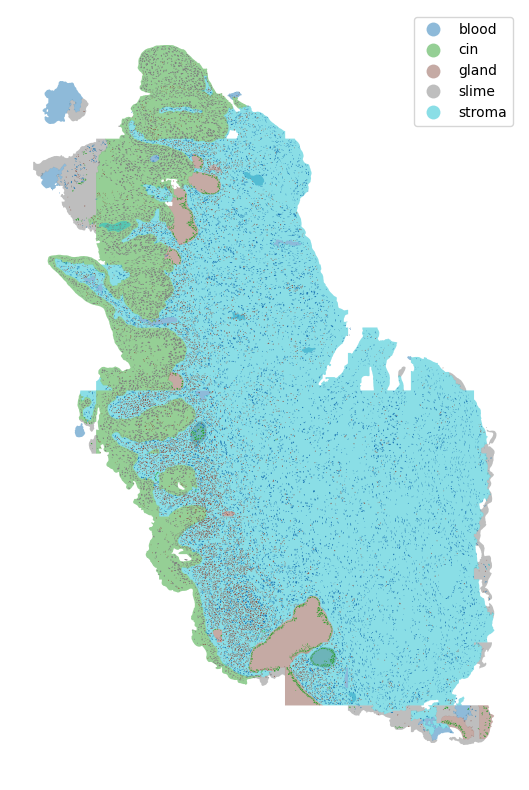

In [1]:
import matplotlib.pyplot as plt
from histolytics.data import cervix_nuclei, cervix_tissue

tis = cervix_tissue()
nuc = cervix_nuclei()

fig, ax = plt.subplots(figsize=(10, 10))
tis.plot(ax=ax, column="class_name", aspect=1, alpha=0.5, legend=True)
nuc.plot(ax=ax, column="class_name", aspect=1, legend=False)
ax.set_axis_off()

### Tissue Interfaces

Histolytics provides a simple way to find interface regions between two tissues, the `get_interfaces`-function. Useful for defining regions, such as the tumor-stroma interface or the invasive margin of a tumor that both have clinical significance. We will extract the interface regions between the CIN lesion and the surrounding stroma to define the lesion-stroma-interface. We will use 300 pixels as the interface breadth. The breadth of the interface region is a user defined parameter that can be adjusted based on the specific requirements of the analysis.

,class_name,geometry
0,lesion-stroma-interface,"POLYGON ((1588.71 4829.03, 1591.18 4828.83, 15..."
1,lesion-stroma-interface,"POLYGON ((743.07 5587.48, 743.63 5589, 744.07 ..."
2,lesion-stroma-interface,"POLYGON ((1151 7566, 1150 7567, 1148.2 7568.2,..."
3,lesion-stroma-interface,"POLYGON ((1891.19 8717.83, 1894.67 8716.8, 189..."
4,lesion-stroma-interface,"POLYGON ((2226 8704.89, 2225.93 8702.52, 2224...."


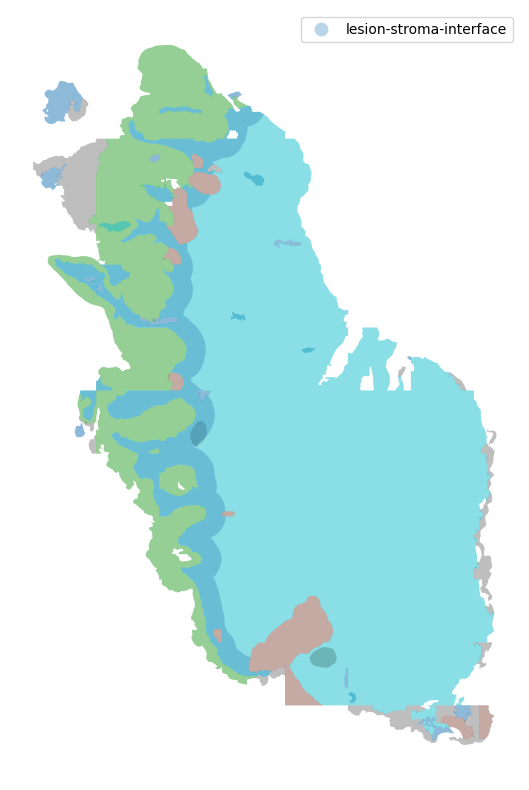

In [ ]:
from histolytics.spatial_ops import get_interfaces

# get the stroma and lesion (cin) tissue segmentations
stroma = tis[tis["class_name"] == "stroma"]
cin_tissue = tis[tis["class_name"] == "cin"]

interface = get_interfaces(cin_tissue, stroma, buffer_dist=300)
interface = interface.assign(class_name="lesion-stroma-interface")

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
interface.plot(ax=ax, column="class_name", aspect=1, alpha=0.3, legend=True)
ax.set_axis_off()
interface.head()

Now it would be easy for example to query for cells residing in the interface region. For example, we could query for all the connective and inflammatory cells within the lesion-stroma interface and compute their ratio to see is the interface region immune or fibroblast hot (if above 1 there is more inflammation in the interface):

2.471516213847502

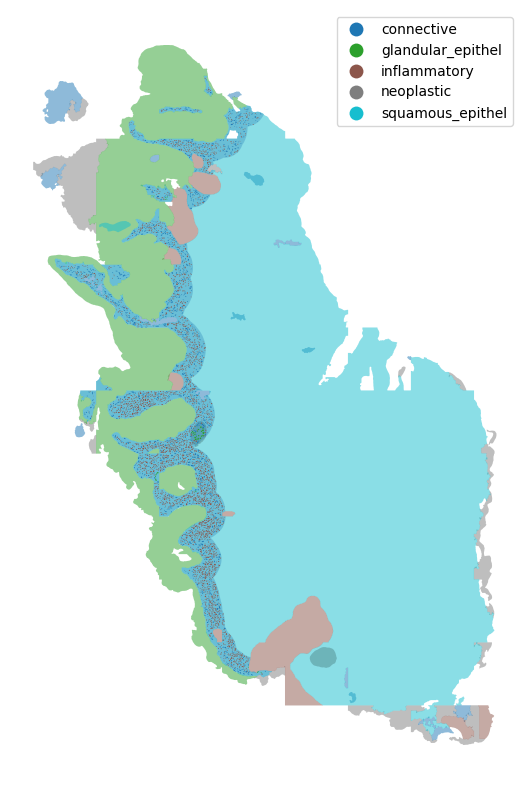

In [3]:
from histolytics.spatial_ops import get_objs

nuc_within_interface = get_objs(interface, nuc, predicate="contains")

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
interface.plot(ax=ax, column="class_name", aspect=1, alpha=0.3, legend=False)
nuc_within_interface.plot(
    ax=ax,
    column="class_name",
    aspect=1,
    legend=True,
)
ax.set_axis_off()

class_counts = nuc_within_interface["class_name"].value_counts()
inflammatory_count = class_counts.get("inflammatory", 0)
connective_count = class_counts.get("connective", 0)

inflammatory_count / connective_count

### Grid Partitioning

Next up are the grid partitions. Grid partitioning is sometimes called spatial indexing in geospatial analysis. We can create a grid over the tissue section. This allows us to analyze the spatial distribution of cell types within each grid cell at different tissues. Histolytics supports hexagonal (h3) and regular rectangular grids for partitioning. We will showcase both:

#### 1. H3 Hexagonal Grid Partitioning

First the hexagonal grid. We will fit the grid with three distinct resolutions. The higher the resolution, the smaller the hexagons and the more detailed the partitioning. We will fit the grids to the stromal regions of the segmented biopsy:

,geometry
8982a939503ffff,"POLYGON ((6672.79721 859.08743, 6647.90711 661..."
8982a939877ffff,"POLYGON ((2556.61731 5658.46273, 2581.53692 58..."
8982a939c4bffff,"POLYGON ((4546.44516 4059.58249, 4366.53531 39..."
8982a93917bffff,"POLYGON ((6221.15607 3971.09325, 6041.22381 38..."
8982a939a7bffff,"POLYGON ((4399.78122 8249.68626, 4219.8982 815..."


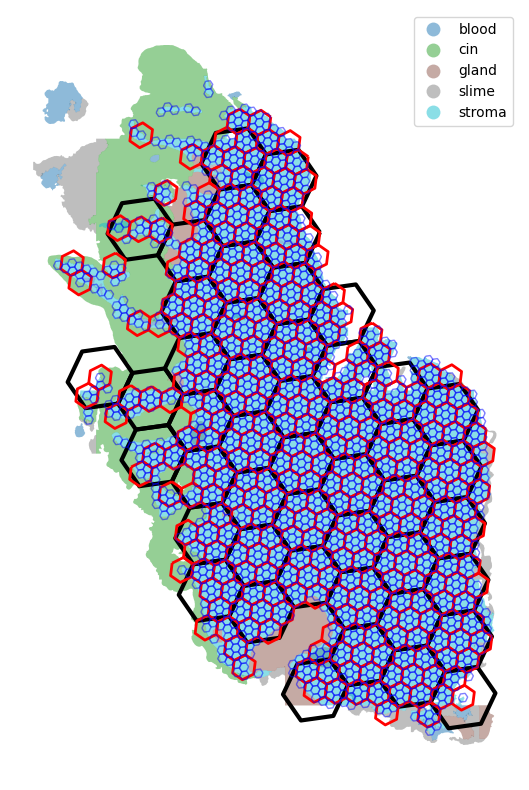

In [4]:
from histolytics.spatial_ops.h3 import h3_grid

h3_res8 = h3_grid(stroma, resolution=8)
h3_res9 = h3_grid(stroma, resolution=9)
h3_res10 = h3_grid(stroma, resolution=10)
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=True)
h3_res8.plot(ax=ax, aspect=1, legend=False, facecolor="none", edgecolor="black", lw=3)
h3_res9.plot(ax=ax, aspect=1, legend=False, facecolor="none", edgecolor="red", lw=2)
h3_res10.plot(
    ax=ax, aspect=1, legend=False, facecolor="none", edgecolor="blue", lw=1, alpha=0.5
)
ax.set_axis_off()
h3_res9.head(5)

We could also fit the grid to the interface region we just defined. This would allow us to analyze the spatial distribution of cell types at the interface between the lesion and stroma.

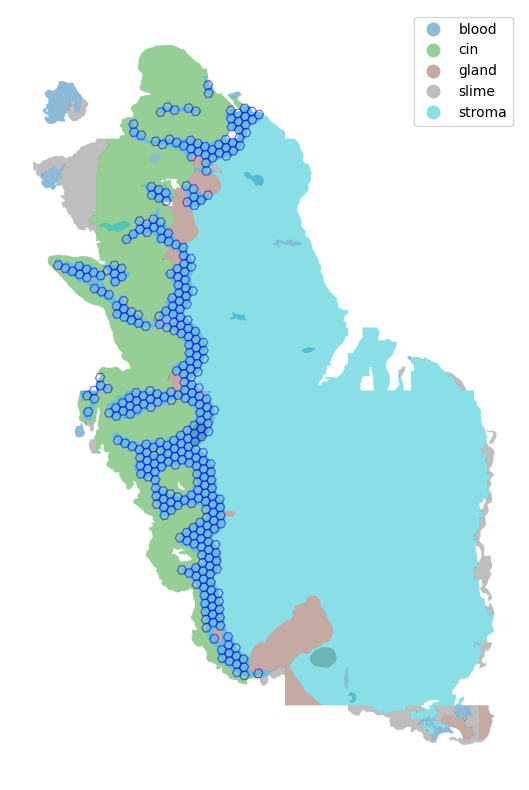

In [5]:
h3_res10_inter = h3_grid(interface, resolution=10)
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=True)
interface.plot(ax=ax, column="class_name", aspect=1, alpha=0.3, legend=False)
h3_res10_inter.plot(
    ax=ax, aspect=1, legend=True, facecolor="none", edgecolor="blue", lw=1, alpha=0.5
)
ax.set_axis_off()

#### 2. Rectangular Grid Partitioning

Next, we will create a rectangular grid over the tissue section. Similar to the hexagonal grid, we can specify the resolution and overlap of the grid cells. The `resolution` parameter defines the size of each grid cell, while the `overlap` parameter controls the amount of overlap between adjacent cells. This time we will fit the grid to the lesion regions of the segmented biopsy using the intersects spatial predicate:


,geometry
0,"POLYGON ((2771 938, 3027 938, 3027 1194, 2771 ..."
1,"POLYGON ((3027 938, 3283 938, 3283 1194, 3027 ..."
2,"POLYGON ((3283 938, 3539 938, 3539 1194, 3283 ..."
3,"POLYGON ((3539 938, 3795 938, 3795 1194, 3539 ..."
4,"POLYGON ((2515 1194, 2771 1194, 2771 1450, 251..."


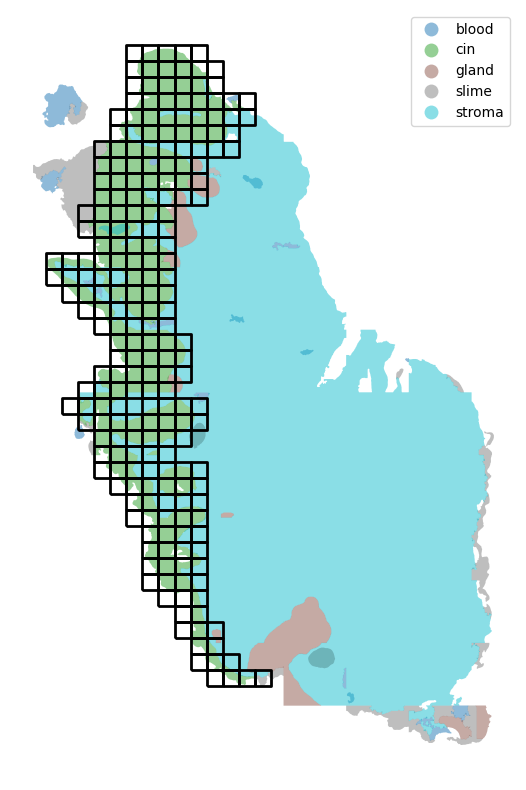

In [6]:
from histolytics.spatial_ops.rect_grid import rect_grid

rect_grid_res256 = rect_grid(
    cin_tissue, resolution=(256, 256), overlap=0, predicate="intersects"
)

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=True)
rect_grid_res256.plot(
    ax=ax, aspect=1, legend=True, facecolor="none", edgecolor="black", lw=2
)

ax.set_axis_off()
rect_grid_res256.head(5)

### Grid Aggregation

Next, we will showcase how to use the grid cells for spatial aggregation tasks. In general, with Histolytics, you can flexibly create aggregation metrics to compute any biological phenomena of interest using the `grid_aggregate` function. It is designed to work with only custom aggregation functions. 

In this example, we will use the hexagonal grid that was fitted over the interface region of the stroma, and compute the inflammatory to connective cell ratio for each grid cell. This allows us to pinpoint regions with high inflammation rather than rely on a global statistic.   

,geometry,immune_connective_ratio,immune_connective_ratio_qnorm
8a82a938225ffff,"POLYGON ((3413.63457 1373.25558, 3372.90649 14...",4.25,0.802023
8a82a939c307fff,"POLYGON ((2943.1294 2991.85151, 2975.94699 306...",4.75,0.835260
8a82a939b22ffff,"POLYGON ((772.20801 7544.76326, 812.90611 7485...",0.80,0.232659
8a82a9399c87fff,"POLYGON ((1355.27663 5295.12391, 1281.75405 52...",1.25,0.372832
8a82a9398baffff,"POLYGON ((2105.08282 4558.47091, 2072.26614 44...",4.75,0.835260


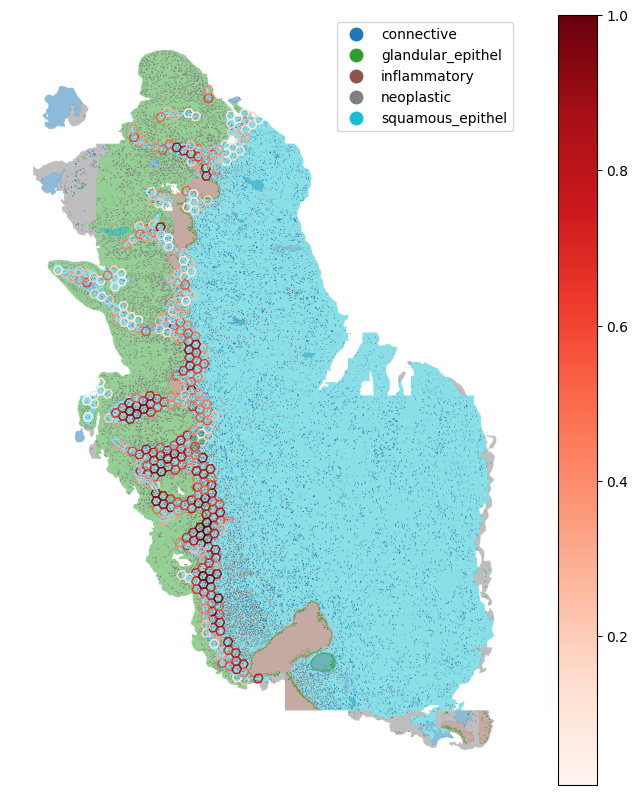

In [ ]:
from histolytics.spatial_agg import grid_aggregate
from scipy.stats import rankdata


# This function will compute the ratio of immune to connective cells within each grid cell
# In general, any function that takes a GeoDataFrame and returns a scalar
# can be used here. Typically, this will be a function that calculates
# a count, sum, mean, or other statistic of interest out of the nuclei.
def immune_connective_ratio(nuclei):
    """Calculate the immune to connective cell ratio in a grid cell."""
    if "inflammatory" in nuclei.value_counts("class_name"):
        immune_cnt = nuclei.value_counts("class_name", normalize=True)["inflammatory"]
    else:
        immune_cnt = 0

    if "connective" in nuclei.value_counts("class_name"):
        connective_cnt = nuclei.value_counts("class_name", normalize=True)["connective"]
    else:
        connective_cnt = 0

    if connective_cnt > 0:
        return float(immune_cnt / connective_cnt)
    else:
        return 0


h3_res10_inter = grid_aggregate(
    objs=nuc,
    grid=h3_res10_inter,
    metric_func=immune_connective_ratio,
    new_col_names=["immune_connective_ratio"],
    predicate="intersects",
    num_processes=2,
)

# We will quantile normalize the result to smooth out extremes
ranks = rankdata(h3_res10_inter["immune_connective_ratio"], method="average")
quantile_normalized = (ranks - 1) / (len(ranks) - 1)
h3_res10_inter = h3_res10_inter.assign(
    immune_connective_ratio_qnorm=quantile_normalized
)

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
nuc.plot(ax=ax, column="class_name", aspect=1, legend=True)
h3_res10_inter.plot(
    ax=ax,
    column="immune_connective_ratio_qnorm",
    cmap="Reds",
    legend=True,
    aspect=1,
    facecolor="none",
)
ax.set_axis_off()
h3_res10_inter.head(5)

### Benchmarking

#### H3 Partitioning
The partitioning of the tissue regions is generally fast to do. The higher the resolution is the more it takes to compute the grid. For example, partitioning the stroma in this segmented biopsy into a hexagonal grid at resolution 9 takes around 400ms on average, whereas with resolution 10 the run time can be over a second:

In [ ]:
%%timeit
h3_grid(stroma, resolution=9)

400 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
h3_grid(stroma, resolution=10)

1.73 s ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Rect Grid Partitioning

With rectangular grid, the partitioning speed also depends on resolution and overlap parameters since they affect the number of grid cells that need to be processed. Higher resolutions and larger overlaps will generally lead to longer processing times. However, the rectangular grid fitting is generally a lot faster than hexagonal grid fitting:

In [ ]:
%%timeit
rect_grid(stroma, resolution=(256, 256), overlap=0, predicate="intersects")

62 ms ± 351 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
rect_grid(stroma, resolution=(512, 512), overlap=0, predicate="intersects")

18.5 ms ± 287 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Grid Aggregation

The grid aggregation metric efficiency depends on the number of grid cells used. The `grid_aggregate` function is parallelizable with respect to the number of grid cells so the runtimes can be reduced with respect to computational resources. For example, our example of computing the immune to connective cell ratio could be sped up by increasing the number of cores:

In [ ]:
%%timeit
# two cores
grid_aggregate(
    objs=nuc,
    grid=h3_res10_inter,
    metric_func=immune_connective_ratio,
    new_col_names=["immune_connective_ratio"],
    predicate="intersects",
    num_processes=2,
)

610 ms ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
# four cores
grid_aggregate(
    objs=nuc,
    grid=h3_res10_inter,
    metric_func=immune_connective_ratio,
    new_col_names=["immune_connective_ratio"],
    predicate="intersects",
    num_processes=4,
)

478 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
